In [1]:
import torch
print(f"CUDA disponible: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU detectada: {torch.cuda.get_device_name(0)}")
else:
    print("¡ADVERTENCIA! No se detectó GPU. El entrenamiento será muy lento en CPU.")

CUDA disponible: True
GPU detectada: NVIDIA GeForce GTX 1650 Ti


In [3]:
import os
import json
import torch
import torch.backends.cudnn as cudnn
import gc
from torch.utils.data import Dataset
from PIL import Image
from transformers import DetrImageProcessor, DetrForObjectDetection, TrainingArguments, Trainer
import evaluate
import numpy as np
from tqdm.auto import tqdm

# Optimizaciones de memoria y rendimiento
torch.backends.cudnn.benchmark = True
gc.collect()
torch.cuda.empty_cache()

# ==== CONFIGURACIÓN ====
NUM_CLASSES = 5  # Número de clases en tu dataset
MODEL_NAME = "facebook/detr-resnet-50"
MAX_IMAGE_SIZE = (400, 300)  # Reducido para mayor velocidad / Tamaño máximo de las imágenes (ancho, alto)

# Corregir las rutas usando os.path.join para compatibilidad multiplataforma
BASE_DIR = "modelo_yolov11_dataset_completo"
TRAIN_JSON = os.path.join(BASE_DIR, "train", "train_coco.json")
VAL_JSON = os.path.join(BASE_DIR, "val", "val_coco.json")
TEST_JSON = os.path.join(BASE_DIR, "test", "test_coco.json")
TRAIN_IMG_DIR = os.path.join(BASE_DIR, "train", "images")
VAL_IMG_DIR = os.path.join(BASE_DIR, "val", "images")
TEST_IMG_DIR = os.path.join(BASE_DIR, "test", "images")

# Verificar que las rutas existen
for path in [TRAIN_JSON, VAL_JSON, TEST_JSON, TRAIN_IMG_DIR, VAL_IMG_DIR, TEST_IMG_DIR]:
    if not os.path.exists(path):
        print(f"¡Advertencia! No se encuentra: {path}")

class COCODataset(Dataset):
    def __init__(self, json_file, image_dir, processor, max_samples=None):
        # Cargar anotaciones COCO
        print(f"Cargando anotaciones de {json_file}...")
        with open(json_file) as f:
            self.coco = json.load(f)
        
        # Crear mapeos de categorías
        self.categories = {cat["id"]: idx for idx, cat in enumerate(self.coco["categories"])}
        
        # Mapear imágenes y anotaciones
        self.images = {img["id"]: img for img in self.coco["images"]}
        self.img_to_anns = {}
        for ann in self.coco["annotations"]:
            if ann["image_id"] not in self.img_to_anns:
                self.img_to_anns[ann["image_id"]] = []
            # Convertir la categoría al índice correcto
            ann_copy = ann.copy()
            ann_copy["category_id"] = self.categories[ann["category_id"]]
            self.img_to_anns[ann["image_id"]].append(ann_copy)
        
        self.image_ids = list(self.images.keys())
        if max_samples is not None:
            self.image_ids = self.image_ids[:max_samples]
        
        self.image_dir = image_dir
        self.processor = processor

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_info = self.images[image_id]
        image_path = os.path.join(self.image_dir, image_info["file_name"])
        
        try:
            image = Image.open(image_path).convert("RGB")
            image.thumbnail(MAX_IMAGE_SIZE, Image.Resampling.LANCZOS)
        except Exception as e:
            print(f"Error al cargar imagen {image_path}: {e}")
            return self.__getitem__((idx + 1) % len(self))

        # Preparar anotaciones
        annotations = self.img_to_anns.get(image_id, [])
        boxes = []
        classes = []
        
        for ann in annotations:
            x, y, w, h = ann["bbox"]
            x = max(0, x)
            y = max(0, y)
            w = min(w, image.size[0] - x)
            h = min(h, image.size[1] - y)
            
            if w > 0 and h > 0:
                boxes.append([x, y, x + w, y + h])
                classes.append(ann["category_id"])

        # Crear tensores
        if not boxes:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            classes = torch.zeros(0, dtype=torch.long)
        else:
            boxes = torch.tensor(boxes, dtype=torch.float32)
            classes = torch.tensor(classes, dtype=torch.long)

        try:
            encoding = self.processor(images=image, return_tensors="pt")
            encoding["labels"] = {
                "boxes": boxes,
                "labels": classes,
                "class_labels": classes,
                "image_id": torch.tensor([image_id])
            }
            encoding["pixel_values"] = encoding["pixel_values"].squeeze(0)
            return encoding
        except Exception as e:
            print(f"Error al procesar imagen {image_path}: {e}")
            return self.__getitem__((idx + 1) % len(self))

def collate_fn(batch):
    pixel_values = []
    labels = []
    
    for item in batch:
        if item is None:
            continue
        pixel_values.append(item["pixel_values"])
        label_dict = {
            "boxes": item["labels"]["boxes"],
            "labels": item["labels"]["labels"],
            "class_labels": item["labels"]["labels"]
        }
        labels.append(label_dict)
    
    if not pixel_values:
        raise ValueError("El batch está vacío después de filtrar elementos None")
    
    return {
        "pixel_values": torch.stack(pixel_values),
        "labels": labels
    }

class CustomTrainer(Trainer):
    def training_step(self, *args, **kwargs):
        loss = super().training_step(*args, **kwargs)
        if self.state.global_step % 100 == 0:
            gc.collect()
            torch.cuda.empty_cache()
        return loss

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    
    # Convertir predicciones a formato COCO
    processed_predictions = []
    processed_labels = []
    
    for pred, label in zip(predictions, labels):
        try:
            # Verificar si las predicciones están en el formato correcto
            if isinstance(pred, dict):
                pred_dict = pred
            else:
                # DETR devuelve (logits, boxes)
                logits, boxes = pred
                scores = torch.nn.functional.softmax(logits, dim=-1)
                max_scores, pred_labels = scores.max(-1)
                pred_dict = {
                    "scores": max_scores,
                    "labels": pred_labels,
                    "boxes": boxes
                }
            
            # Procesar las etiquetas
            label_dict = {}
            if isinstance(label, dict):
                # Si es un diccionario, verificar las claves necesarias
                if "boxes" in label:
                    label_dict["boxes"] = label["boxes"]
                else:
                    label_dict["boxes"] = torch.tensor([])
                
                if "labels" in label:
                    label_dict["labels"] = label["labels"]
                elif "class_labels" in label:
                    label_dict["labels"] = label["class_labels"]
                else:
                    label_dict["labels"] = torch.tensor([])
            else:
                # Si no es un diccionario, asumir que son las cajas
                label_dict = {
                    "boxes": label if label is not None else torch.tensor([]),
                    "labels": torch.zeros(len(label) if label is not None else 0, dtype=torch.long)
                }
            
            # Añadir a las listas procesadas
            processed_predictions.append(pred_dict)
            processed_labels.append(label_dict)
            
        except Exception as e:
            print(f"Error procesando una muestra: {str(e)}")
            continue
    
    try:
        # Calcular mAP
        metrics = evaluate.load("mean_average_precision")
        results = metrics.compute(
            predictions=processed_predictions,
            references=processed_labels
        )
        
        return results
    except Exception as e:
        print(f"Error al calcular métricas: {str(e)}")
        return {"error": str(e)}

def mostrar_resultados_finales(trainer):
    """
    Muestra un resumen detallado de los resultados del entrenamiento
    """
    print("\n" + "="*50)
    print("RESULTADOS FINALES DEL ENTRENAMIENTO")
    print("="*50)
    
    # Evaluar en el conjunto de validación
    print("\nEvaluando en el conjunto de validación...")
    metrics = trainer.evaluate()
    
    print("\nMétricas de evaluación:")
    print("-"*30)
    
    # Mostrar métricas principales
    if 'eval_map' in metrics:
        print(f"mAP promedio: {metrics['eval_map']:.4f}")
    
    if 'eval_map_50' in metrics:
        print(f"mAP@50: {metrics['eval_map_50']:.4f}")
    
    if 'eval_map_75' in metrics:
        print(f"mAP@75: {metrics['eval_map_75']:.4f}")
    
    # Mostrar métricas por clase si están disponibles
    if 'eval_map_per_class' in metrics:
        print("\nRendimiento por clase:")
        print("-"*30)
        for class_id, map_value in enumerate(metrics['eval_map_per_class']):
            print(f"Clase {class_id}: mAP = {map_value:.4f}")
    
    print("\nMétricas adicionales:")
    print("-"*30)
    for key, value in metrics.items():
        if key not in ['eval_map', 'eval_map_50', 'eval_map_75', 'eval_map_per_class']:
            if isinstance(value, float):
                print(f"{key}: {value:.4f}")
            else:
                print(f"{key}: {value}")
    
    print("\n" + "="*50)

def main():
    # Cargar el modelo y el procesador
    print("Cargando modelo y procesador...")
    processor = DetrImageProcessor.from_pretrained(MODEL_NAME)
    model = DetrForObjectDetection.from_pretrained(
        MODEL_NAME,
        num_labels=NUM_CLASSES,
        ignore_mismatched_sizes=True,
        id2label={str(i): f"class_{i}" for i in range(NUM_CLASSES)},
        label2id={f"class_{i}": i for i in range(NUM_CLASSES)}
    )

    # Congelar el backbone y el transformer
    print("Congelando capas...")
    for name, param in model.named_parameters():
        if 'backbone' in name or 'encoder' in name or 'decoder' in name:
            param.requires_grad = False
        if 'class_embed' in name or 'bbox_embed' in name:
            param.requires_grad = True

    # Mover el modelo a GPU si está disponible
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Cargar datasets
    print("Cargando datasets...")
    full_train_dataset = COCODataset(TRAIN_JSON, TRAIN_IMG_DIR, processor, max_samples=None)
    full_val_dataset = COCODataset(VAL_JSON, VAL_IMG_DIR, processor, max_samples=None)
    
    import random
    train_indices = random.sample(range(len(full_train_dataset)), len(full_train_dataset)//2)
    val_indices = random.sample(range(len(full_val_dataset)), len(full_val_dataset)//2)
    
    # Crear subconjuntos usando los índices aleatorios
    from torch.utils.data import Subset
    train_dataset = Subset(full_train_dataset, train_indices)
    val_dataset = Subset(full_val_dataset, val_indices)
    
    print(f"Tamaño del dataset de entrenamiento: {len(train_dataset)}")
    print(f"Tamaño del dataset de validación: {len(val_dataset)}")

    # Configurar el entrenamiento
    training_args = TrainingArguments(
        output_dir="./detr-finetuned-congelado",
        per_device_train_batch_size=6,  # Reducido para inicio más rápido
        per_device_eval_batch_size=4,
        num_train_epochs=10,
        eval_strategy="steps",
        save_strategy="steps",
        logging_dir="./logs",
        learning_rate=1e-3,
        weight_decay=1e-4,
        save_total_limit=1,
        remove_unused_columns=False,
        fp16=False,
        report_to="tensorboard",
        load_best_model_at_end=True,
        metric_for_best_model="loss",
        greater_is_better=True,
        gradient_accumulation_steps=4,
        eval_accumulation_steps=4,
        dataloader_num_workers=0,  # Cambiado a 0 para inicio más rápido
        dataloader_pin_memory=False,
        logging_steps=10,  # Mostrar progreso en cada paso
        warmup_steps=100,  # Reducido para ver progreso más rápido
        max_grad_norm=0.1,
        eval_steps=500,
        save_steps=500,
        logging_first_step=True,  # Asegura logging inmediato
        logging_nan_inf_filter=False,  # Muestra todos los logs
        disable_tqdm=False  # Asegura que se muestre la barra de progreso
    )

    # Inicializar el trainer
    trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        data_collator=collate_fn,
        compute_metrics=compute_metrics,
        tokenizer=processor
    )

    # Entrenar el modelo
    print("Iniciando entrenamiento...")
    trainer.train()

if __name__ == "__main__":
    main()

Cargando modelo y procesador...


Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

Congelando capas...
Cargando datasets...
Cargando anotaciones de modelo_yolov11_dataset_completo\train\train_coco.json...
Cargando anotaciones de modelo_yolov11_dataset_completo\val\val_coco.json...
Tamaño del dataset de entrenamiento: 4116
Tamaño del dataset de validación: 492
Iniciando entrenamiento...


C:\Users\carra\AppData\Local\Temp\ipykernel_23328\1065434868.py:332: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


Step,Training Loss,Validation Loss,Error
500,2393.859200,1390.503296,Couldn't find a module script at c:\Users\carra\OneDrive\Escritorio\UNIVERSIDAD\SEPTIMO\IMAGENES Y VISION\PROYECTO\mean_average_precision\mean_average_precision.py. Module 'mean_average_precision' doesn't exist on the Hugging Face Hub either.
1000,1468.773300,1390.495728,Couldn't find a module script at c:\Users\carra\OneDrive\Escritorio\UNIVERSIDAD\SEPTIMO\IMAGENES Y VISION\PROYECTO\mean_average_precision\mean_average_precision.py. Module 'mean_average_precision' doesn't exist on the Hugging Face Hub either.
1500,2658.195500,1390.497314,Couldn't find a module script at c:\Users\carra\OneDrive\Escritorio\UNIVERSIDAD\SEPTIMO\IMAGENES Y VISION\PROYECTO\mean_average_precision\mean_average_precision.py. Module 'mean_average_precision' doesn't exist on the Hugging Face Hub either.


Error procesando una muestra: too many values to unpack (expected 2)
Error procesando una muestra: too many values to unpack (expected 2)
Error procesando una muestra: too many values to unpack (expected 2)
Error al calcular métricas: Couldn't find a module script at c:\Users\carra\OneDrive\Escritorio\UNIVERSIDAD\SEPTIMO\IMAGENES Y VISION\PROYECTO\mean_average_precision\mean_average_precision.py. Module 'mean_average_precision' doesn't exist on the Hugging Face Hub either.
Error procesando una muestra: too many values to unpack (expected 2)
Error procesando una muestra: too many values to unpack (expected 2)
Error procesando una muestra: too many values to unpack (expected 2)
Error al calcular métricas: Couldn't find a module script at c:\Users\carra\OneDrive\Escritorio\UNIVERSIDAD\SEPTIMO\IMAGENES Y VISION\PROYECTO\mean_average_precision\mean_average_precision.py. Module 'mean_average_precision' doesn't exist on the Hugging Face Hub either.
Error procesando una muestra: too many value

In [14]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    
    # Convertir predicciones a formato COCO
    processed_predictions = []
    processed_labels = []
    
    # Inicializar contadores para métricas por clase
    class_metrics = {i: {"tp": 0, "fp": 0, "fn": 0} for i in range(NUM_CLASSES)}
    
    for pred, label in zip(predictions, labels):
        try:
            if isinstance(pred, dict):
                pred_dict = pred
            else:
                logits, boxes = pred
                scores = torch.nn.functional.softmax(logits, dim=-1)
                max_scores, pred_labels = scores.max(-1)
                pred_dict = {
                    "scores": max_scores,
                    "labels": pred_labels,
                    "boxes": boxes
                }
            
            label_dict = {}
            if isinstance(label, dict):
                if "boxes" in label:
                    label_dict["boxes"] = label["boxes"]
                else:
                    label_dict["boxes"] = torch.tensor([])
                
                if "labels" in label:
                    label_dict["labels"] = label["labels"]
                elif "class_labels" in label:
                    label_dict["labels"] = label["class_labels"]
                else:
                    label_dict["labels"] = torch.tensor([])
            else:
                label_dict = {
                    "boxes": label if label is not None else torch.tensor([]),
                    "labels": torch.zeros(len(label) if label is not None else 0, dtype=torch.long)
                }
            
            # Calcular métricas por clase
            pred_labels = pred_dict["labels"]
            true_labels = label_dict["labels"]
            
            for class_id in range(NUM_CLASSES):
                pred_mask = pred_labels == class_id
                true_mask = true_labels == class_id
                
                # True Positives
                tp = (pred_mask & true_mask).sum().item()
                # False Positives
                fp = (pred_mask & ~true_mask).sum().item()
                # False Negatives
                fn = (~pred_mask & true_mask).sum().item()
                
                class_metrics[class_id]["tp"] += tp
                class_metrics[class_id]["fp"] += fp
                class_metrics[class_id]["fn"] += fn
            
            processed_predictions.append(pred_dict)
            processed_labels.append(label_dict)
            
        except Exception as e:
            print(f"Error procesando una muestra: {str(e)}")
            continue
    
    try:
        # Calcular mAP usando la biblioteca evaluate
        metrics = evaluate.load("mean_average_precision")
        map_results = metrics.compute(
            predictions=processed_predictions,
            references=processed_labels
        )
        
        # Calcular precision, recall y accuracy por clase
        results = {}
        results.update(map_results)  # Incluir resultados de mAP
        
        # Calcular métricas por clase
        precision_per_class = []
        recall_per_class = []
        accuracy_per_class = []
        
        for class_id in range(NUM_CLASSES):
            tp = class_metrics[class_id]["tp"]
            fp = class_metrics[class_id]["fp"]
            fn = class_metrics[class_id]["fn"]
            
            # Precision
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            precision_per_class.append(precision)
            
            # Recall
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            recall_per_class.append(recall)
            
            # Accuracy
            accuracy = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0
            accuracy_per_class.append(accuracy)
        
        # Agregar métricas por clase al diccionario de resultados
        results["precision_per_class"] = precision_per_class
        results["recall_per_class"] = recall_per_class
        results["accuracy_per_class"] = accuracy_per_class
        
        # Agregar promedios generales
        results["mean_precision"] = np.mean(precision_per_class)
        results["mean_recall"] = np.mean(recall_per_class)
        results["mean_accuracy"] = np.mean(accuracy_per_class)
        
        return results
    except Exception as e:
        print(f"Error al calcular métricas: {str(e)}")
        return {"error": str(e)}

def mostrar_resultados_finales(trainer):
    """
    Muestra un resumen detallado de los resultados del entrenamiento
    """
    print("\n" + "="*50)
    print("RESULTADOS FINALES DEL ENTRENAMIENTO")
    print("="*50)
    
    # Evaluar en el conjunto de validación
    print("\nEvaluando en el conjunto de validación...")
    metrics = trainer.evaluate()
    
    print("\nMétricas Generales:")
    print("-"*30)
    print(f"Precisión Media: {metrics.get('mean_precision', 0):.4f}")
    print(f"Recall Medio: {metrics.get('mean_recall', 0):.4f}")
    print(f"Accuracy Media: {metrics.get('mean_accuracy', 0):.4f}")
    print(f"mAP promedio: {metrics.get('eval_map', 0):.4f}")
    
    print("\nMétricas por Clase:")
    print("-"*30)
    for class_id in range(NUM_CLASSES):
        print(f"\nClase {class_id}:")
        print(f"  Precisión: {metrics.get('precision_per_class', [0]*NUM_CLASSES)[class_id]:.4f}")
        print(f"  Recall: {metrics.get('recall_per_class', [0]*NUM_CLASSES)[class_id]:.4f}")
        print(f"  Accuracy: {metrics.get('accuracy_per_class', [0]*NUM_CLASSES)[class_id]:.4f}")
        if 'eval_map_per_class' in metrics:
            print(f"  mAP: {metrics['eval_map_per_class'][class_id]:.4f}")
    
    print("\n" + "="*50)

In [15]:
# Cargar el modelo entrenado
model_path = "./detr-finetuned-congelado/checkpoint-500"
processor = DetrImageProcessor.from_pretrained(model_path)
model = DetrForObjectDetection.from_pretrained(model_path)

# Configurar el trainer para evaluación
training_args = TrainingArguments(
    output_dir="./eval_results",
    per_device_eval_batch_size=4,
    remove_unused_columns=False
)

# Crear el dataset de evaluación
eval_dataset = COCODataset(VAL_JSON, VAL_IMG_DIR, processor)

# Inicializar el trainer
trainer = CustomTrainer(
    model=model,
    args=training_args,
    eval_dataset=eval_dataset,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor
)

# Realizar la evaluación y mostrar resultados
mostrar_resultados_finales(trainer)

Cargando anotaciones de modelo_yolov11_dataset_completo\val\val_coco.json...


C:\Users\carra\AppData\Local\Temp\ipykernel_23328\2144776834.py:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(



RESULTADOS FINALES DEL ENTRENAMIENTO

Evaluando en el conjunto de validación...


Error procesando una muestra: 'labels'
Error procesando una muestra: too many values to unpack (expected 2)
Error procesando una muestra: too many values to unpack (expected 2)
Error procesando una muestra: too many values to unpack (expected 2)
Error al calcular métricas: Couldn't find a module script at c:\Users\carra\OneDrive\Escritorio\UNIVERSIDAD\SEPTIMO\IMAGENES Y VISION\PROYECTO\mean_average_precision\mean_average_precision.py. Module 'mean_average_precision' doesn't exist on the Hugging Face Hub either.

Métricas Generales:
------------------------------
Precisión Media: 0.0000
Recall Medio: 0.0000
Accuracy Media: 0.0000
mAP promedio: 0.0000

Métricas por Clase:
------------------------------

Clase 0:
  Precisión: 0.0000
  Recall: 0.0000
  Accuracy: 0.0000

Clase 1:
  Precisión: 0.0000
  Recall: 0.0000
  Accuracy: 0.0000

Clase 2:
  Precisión: 0.0000
  Recall: 0.0000
  Accuracy: 0.0000

Clase 3:
  Precisión: 0.0000
  Recall: 0.0000
  Accuracy: 0.0000

Clase 4:
  Precisión: 0.0

In [4]:
def probar_modelo_en_imagen(ruta_imagen, threshold=0.01):
    """
    Prueba el modelo DETR en una imagen y muestra los resultados
    Args:
        ruta_imagen: Ruta a la imagen a probar
        threshold: Umbral de confianza para mostrar las detecciones (default 0.5)
    """
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    from PIL import Image
    import torch
    
    # Cargar el modelo entrenado
    checkpoint_dir = "detr-finetuned-congelado/checkpoint-500"  # Ajusta este número según tu último checkpoint
    model = DetrForObjectDetection.from_pretrained(checkpoint_dir)
    processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
    
    # Mover el modelo a GPU si está disponible
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    
    # Cargar y procesar la imagen
    image = Image.open(ruta_imagen).convert("RGB")
    inputs = processor(images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Realizar la predicción
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Procesar los resultados
    probas = outputs.logits.softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > threshold
    
    # Convertir las cajas al formato de la imagen
    target_sizes = torch.tensor([image.size[::-1]])
    postprocessed_outputs = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=threshold)[0]
    
    # Preparar la visualización
    plt.figure(figsize=(16,10))
    plt.imshow(image)
    ax = plt.gca()
    
    # Definir colores para cada clase
    colors = ['r', 'g', 'b', 'y', 'm']  # Ajusta según el número de clases
    
    # Dibujar las detecciones
    for score, label, box in zip(postprocessed_outputs['scores'], postprocessed_outputs['labels'], postprocessed_outputs['boxes']):
        box = box.cpu().numpy()
        x, y, x2, y2 = box
        width = x2 - x
        height = y2 - y
        
        # Crear el rectángulo
        rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor=colors[label], facecolor='none')
        ax.add_patch(rect)
        
        # Añadir etiqueta con score
        plt.text(x, y, f'Class {label}: {score:.2f}', 
                bbox=dict(facecolor=colors[label], alpha=0.5))
    
    plt.axis('off')
    plt.show()
    
    return postprocessed_outputs

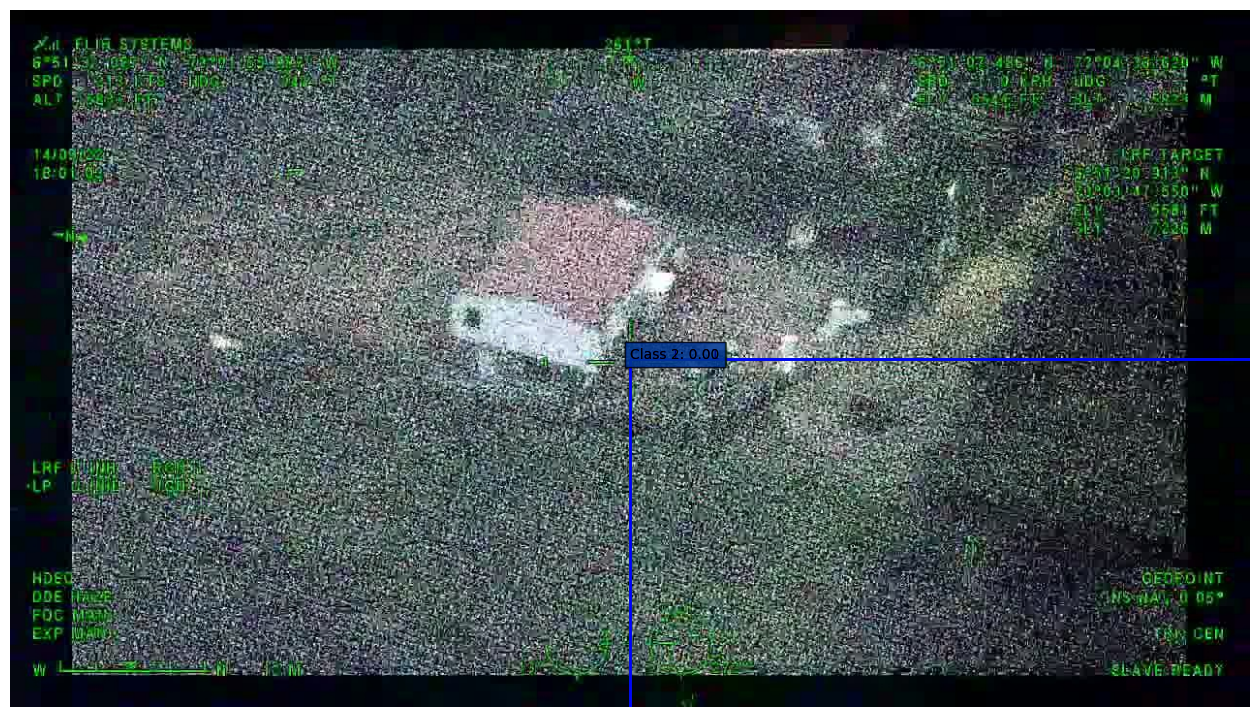

In [10]:
# Ejemplo con una imagen de tu conjunto de prueba
ruta_imagen = "modelo_yolov11_dataset_filtrado/test/images/video_13min_758.jpg"  # Ajusta esta ruta
resultados = probar_modelo_en_imagen(ruta_imagen, threshold=0.001)